In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
import scipy
from skimage.external.tifffile import TiffFile
import sys
import time
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction.cnmf import cnmf

C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Will\Anaconda3\envs\caiman-online\lib\site-

In [3]:
from glob import glob
from ScanImageTiffReader import ScanImageTiffReader

In [6]:
from caiman_online.utils import tic, toc, ptoc

In [7]:
os.chdir('E:/caiman_scratch/ori2')
os.getcwd()

'E:\\caiman_scratch\\ori2'

In [8]:
fnames = glob('./*tif*')[0:30]
# m_orig = cm.load_movie_chain(fnames)
# downsample_ratio = .2  # motion can be perceived better when downsampling in time
# m_orig.resize(1, 1, downsample_ratio).play(q_max=99.5, fr=30, magnification=2)   # play movie (press q to exit)

In [9]:
opts = dict(
max_shifts = (10, 10),
strides =  (48, 48),
overlaps = (24, 24),
num_frames_split = 100,
max_deviation_rigid = 3,
pw_rigid = False,
shifts_opencv = True,
border_nan = 'copy')

In [10]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [63]:
mms = cm.save_memmap_each(
                fnames,
                base_name=f'testmap', 
                order='F',
                slices=[
                    slice(0, -1, 6),
                    slice(0, 512),
                    slice(100, 400)
                ],
            );

mmj = cm.save_memmap(mms, order='C')

   388505386 [mmapping.py:    save_memmap_join():205] [20784] Memmap file for fname_tot: .\Yr_d1_512_d2_300_d3_1_order_C_frames_763_.mmap
   388507361 [mmapping.py:    save_memmap_join():232] [20784] Deleting big mov


In [128]:
mov = cm.load(mm)
mov.resize(1, 1).play(q_max=99.5, fr=30, magnification=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.02it/s]


In [66]:
os.mkdir('./temp')

In [11]:
t = tic()
data = []
for f in fnames:
    with ScanImageTiffReader(f) as reader:
        data.append(reader.data()[slice(0, -1, 6),slice(0, 512),slice(100, 400)])
data = np.concatenate(data)
ptoc(t);
        
        
    

Time elapsed: 1.2625 s


In [73]:
import tifffile

In [150]:
t = tic()
data = []
for f in fnames:
    tif = tifffile.imread(f)
    data.append(tif[slice(0, -1, 6),slice(0, 512),slice(100, 400)])
data = np.concatenate(data)
ptoc(t);


Time elapsed: 4.2877 s


In [151]:
data.shape

(763, 512, 300)

In [86]:
paths = crop_and_save_multiplane(fnames, 0)

'crop_and_save_multiplane' done in 2.942s


In [97]:
c = crop_movie(fnames[0], slice(None), slice(None), slice(0,-1, 6))

In [98]:
c.shape

(26, 512, 512)

In [89]:
# motion correction
dxy = (1.5, 1.5) # spatial resolution in x and y in (um per pixel)
max_shift_um = (12., 12.) # maximum shift in um
patch_motion_xy = (100., 100.) # patch size for non-rigid correction in um


caiman_params = {
    'fr': 6.36,
    'overlaps': (24, 24),
    'max_deviation_rigid': 3,
    'p': 1,  # deconv 0 is off, 1 is slow, 2 is fast
    'nb': 3,  # background compenents -> nb: 3 for complex
    'decay_time': 1.0,  # sensor tau
    'gSig': (5, 5),  # expected half size of neurons in pixels, very important for proper component detection
    'only_init': False,  # has to be `False` when seeded CNMF is used
    'rf': None,  # half-size of the patches in pixels. Should be `None` when seeded CNMF is used.
    'pw_rigid': True,  # piece-wise rigid flag
    'ssub': 1,
    'tsub': 1,
    'do_merge': False, # new found param, testing
    'update_background_components': False,
    'merge_thr': 0.9999,
    'num_frames_split': 20,
    'border_nan': 'copy',
    'max_shifts': [int(a/b) for a, b in zip(max_shift_um, dxy)],
    'strides': tuple([int(a/b) for a, b in zip(patch_motion_xy, dxy)])
}



In [16]:
max_shifts = (10, 10)
strides =  (48, 48)
overlaps = (24, 24)
num_frames_split = 100
max_deviation_rigid = 3
niter_rig = 2
pw_rigid = True
shifts_opencv = True
gSig_filt = (7,7)

In [17]:
# create a motion correction object
logging.basicConfig(level=logging.DEBUG)
t = tic()
mc = MotionCorrect(data, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                   pw_rigid=pw_rigid, 
                  num_frames_split=num_frames_split, niter_rig=niter_rig, gSig_filt=gSig_filt)
ptoc(t)

      414385 [motion_correction.py:            __init__():181] [46272] Creating file for motion correction "tmp_mov_mot_corr.hdf5"
      415129 [timeseries.py:                save():266] [46272] No file saved


Time elapsed: 0.8066 s


0.806580399999973

In [18]:
t = tic()
mc.motion_correct(save_movie=True)
ptoc(t)

      418491 [motion_correction.py:motion_correct_pwrigid():342] [46272] Generating template by rigid motion correction
      418867 [movies.py:      extract_shifts():371] [46272] Movie average is negative. Removing 1st percentile.
      418884 [movies.py:      extract_shifts():389] [46272] Movie average is negative. Removing 1st percentile.
      419357 [movies.py:      extract_shifts():371] [46272] Movie average is negative. Removing 1st percentile.
      419373 [movies.py:      extract_shifts():389] [46272] Movie average is negative. Removing 1st percentile.
      419874 [movies.py:      extract_shifts():371] [46272] Movie average is negative. Removing 1st percentile.
      419891 [movies.py:      extract_shifts():389] [46272] Movie average is negative. Removing 1st percentile.
      420345 [motion_correction.py:motion_correction_piecewise():3030] [46272] ** Starting parallel motion correction **
      430054 [motion_correction.py:motion_correction_piecewise():3038] [46272] ** Finis

Time elapsed: 25.3992 s


25.39918789999996

In [222]:
mov.

ValueError: stat: embedded null character in path

In [175]:
original = cm.movie(data)
original.play(q_max=99.5, fr=30, magnification=2)

In [217]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
# m_rig.play(q_max=99.5, fr=30, magnification=2, bord_px = 0*bord_px_rig) # press q to exit

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


In [218]:
cm.concatenate([original - mc.min_mov*mc.nonneg_movie,
                m_rig], axis=2).play(fr=60, q_max=99.5, magnification=2)

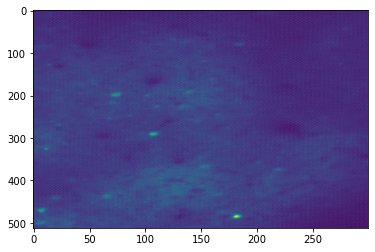

In [116]:
plt.imshow(mc.total_template_rig, aspect='auto')

In [46]:
p = params.CNMFParams(params_dict=opts)

   385456456 [params.py:                 set():969] [20784] Changing key strides in group motion from (96, 96) to (48, 48)
   385456458 [params.py:                 set():969] [20784] Changing key overlaps in group motion from (32, 32) to (24, 24)
   385456461 [params.py:                 set():969] [20784] Changing key num_frames_split in group motion from 80 to 100
   385456462 [params.py:                 set():969] [20784] Changing key pw_rigid in group motion from False to True


In [303]:
cm.source_extraction

<module 'caiman.source_extraction' from 'C:\\Users\\Will\\Anaconda3\\envs\\caiman-online\\lib\\site-packages\\caiman\\source_extraction\\__init__.py'>

In [238]:
mov = cm.load(mc.mmap_file)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


In [240]:
Yr, dims, T = cm.load_memmap(mc.mmap_file[0])
images = np.reshape(Yr.T, [T] + list(dims), order='C') 

In [241]:
cn = cnmf.CNMF(n_processes, params=p, dview=dview)

In [244]:
cn.fit(images)

   397701498 [cnmf.py:                 fit():469] [20784] (763, 512, 300)
   397701499 [cnmf.py:                 fit():486] [20784] Using 31 processes
   397701501 [cnmf.py:                 fit():497] [20784] using 4954 pixels per process
   397701502 [cnmf.py:                 fit():498] [20784] using 5000 block_size_spat
   397701503 [cnmf.py:                 fit():499] [20784] using 5000 block_size_temp
   397701505 [cnmf.py:                 fit():502] [20784] preprocessing ...
   397701507 [pre_processing.py:interpolate_missing_data():53] [20784] Checking for missing data entries (NaN)
   397702441 [cnmf.py:                 fit():505] [20784] initializing ...
   397702444 [initialization.py:initialize_components():308] [20784] Variance Normalization
   397702615 [initialization.py:initialize_components():328] [20784] Spatial/Temporal downsampling 2-photon
   397702796 [initialization.py:           downscale():92] [20784] Downscaling using OpenCV
   397702797 [initialization.py:initi

In [47]:
p.motion['indices']

(slice(None, None, None), slice(None, None, None))

In [245]:
class A:
    def __init__(self, val):
        self.val = val
        
a = A(1)
a.val2

AttributeError: 'A' object has no attribute 'val2'

In [202]:
mc.mmap_file

['.\\tmp_mov_mot_corr._els__d1_512_d2_300_d3_1_order_F_frames_763_.mmap']

In [40]:
import caiman

In [41]:
caiman.__file__


'C:\\Users\\Will\\Anaconda3\\envs\\caiman-online\\lib\\site-packages\\caiman\\__init__.py'

In [305]:
def func1(**kwargs):
    kwargs.setdefault('a', 1)
    print(kwargs)
    
func1()

{'a': 1}


In [306]:
cm.start_server()

   562839914 [cluster.py:        start_server():229] [20784] Starting cluster...


Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json
..............

In [307]:
cm.cluster.start_server()

   562886175 [cluster.py:        start_server():229] [20784] Starting cluster...
